<a href="https://colab.research.google.com/github/shumpei-watanabe3689/Text_Analysis_Final_Project/blob/main/1216TEXT_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **How have key risks in the U.S. financial sector evolved over the past 10 years?**

# Introduction
Financial institutions are required to submit a disclosure document, known as Form 10-K, annually to the SEC. This document spans hundreds of pages and provides both quantitative and qualitative insights, covering topics such as business performances and the status of their risk management.

From the regulators' perspective, it is essential to thoroughly utilize these filings from financial institutions for more effective supervision. Traditionally, quantitative information, such as financial performances, has been the go-to for risk analysis in financial institutions. In contrast, qualitative data, like descriptions of governance structures or institutions' perceptions of their risks, have been underutilized by regulators. However, with advances in programming tools, extracting and analyzing textual information from these documents is now feasible. By doing so, regulators can gain a deeper understanding of what financial institutions view as key risks.

This research seeks to chart the evolution of key risks in the U.S. financial sector by analyzing the text within Form 10-Ks over the past decade by using topic modeling and TF-IDF.


# Data Source
For data acquisition, Users can retrieve information electronically from the SEC’s EDGAR system, which is an online database of public filings maintained by the SEC. This feature allows us to gather the textual data of Form 10-K submitted by financial institutions. To do this, I used a package called “sec-edgar-downloader” of Python.  I used [this page](https://pypi.org/project/sec-edgar-downloader/) as a reference for this part.

In [ ]:
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install sec-edgar-downloader
!pip install tomotopy
import tomotopy as tp
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 10.0 MB/s eta 0:00:00


In this analysis, I focused on the top U.S. financial institutions in terms of total assets. The ranking of financial institutions based on total assets was referenced from data published by the Federal Financial Institutions Examination Council (FFIEC). The criteria for selection were U.S.-headquartered financial institutions with total assets exceeding $100 billion as of September 2022. The period for extracting text data is set from 2013 to 2023, and the sample is limited to financial institutions from which data can be extracted for every year within this timeframe. In this analysis, the total number of financial institution samples amounted to 20.

It should be noted that some financial institutions had variations in their Form 10-K formats or omitted the 'Risk Factors' section entirely (in these cases, it's often simply stated to refer to the descriptions in their annual report). For such institutions, text was manually extracted and directly imported from Google Drive (refer to the code mentioned later).


In [ ]:
from sec_edgar_downloader import Downloader
dl = Downloader("/content/edgar_data", "sw3689@columbia.edu")
# Define tickers for the sample companies
companies = {
    "JP Morgan": "JPM",
    "Goldman": "GS",
    "Charles Schwab" : "SCHW",
    "M&T Bank" :"MTB",
    "Ally Financial" : "ALLY",
    "Huntington" : "HBAN",
    "Ameriprise" : "AMP",
    "Regional Financial Corp" : "RF",
    "Discover Financial Services" : "DFS",
    "NY Community Bank" : "NYCB"
}
# Download the 10-K filings
for name, ticker in companies.items():
    dl.get("10-K", ticker, after="2013-01-01")
    print(f"Downloaded 10-K for {name}")

Downloaded 10-K for JP Morgan
Downloaded 10-K for Goldman
Downloaded 10-K for Charles Schwab
Downloaded 10-K for M&T Bank
Downloaded 10-K for Ally Financial
Downloaded 10-K for Huntington
Downloaded 10-K for Ameriprise
Downloaded 10-K for Regional Financial Corp
Downloaded 10-K for Discover Financial Services
Downloaded 10-K for NY Community Bank


# Data Extraction Method
From each bank's 10-K, I exclusively extracted text from the "Risk Factors" section. To do this, I used [this page](https://gist.github.com/anshoomehra/ead8925ea291e233a5aa2dcaa2dc61b2) as a reference. The basic idea for extracting only the section “Risk Factors” involves utilizing item numbers allocated to each section (for instance, 'Risk Factors' is item 1A), enabling us to instruct Python to extract text beginning from item 1A and continuing up to item 1B.

The function “process_10k_sections(document)” processes a text document to find specific sections ("Item 1A", "Item 1B"). It uses a regular expression (regex) to identify these sections within the document. The regular expression is designed to match variations in how these items might be formatted in the text (like different spacing, the presence of HTML entities like "&#160"; or "& nbsp;").

The function” extract_text_from_html(raw_html)” is designed to extract plain text from HTML content, using BeautifulSoup. It parses the provided raw HTML content (raw_html) using BeautifulSoup with the 'lxml' parser.


In [ ]:
def process_10k_sections(document):
    # Regex to find the specified items
    regex = re.compile(r'(>Item(\s|&#160;|&nbsp;)(1A|1B|7A|7|8)\.{0,1})|(ITEM\s(1A|1B|7A|7|8))')
    matches = [x for x in regex.finditer(document)]

    if not matches:
        return None

    # Creating the dataframe with matches
    test_df = pd.DataFrame([(x.group(), x.start(), x.end()) for x in matches])
    test_df.columns = ['item', 'start', 'end']
    test_df['item'] = test_df.item.str.lower()

    # Cleaning up the dataframe entries
    test_df.replace(['&#160;', '&nbsp;', ' ', '\.', '>'], '', regex=True, inplace=True)

    # Dropping duplicates and setting the item as index
    pos_dat = test_df.sort_values('start', ascending=True).drop_duplicates(subset=['item'], keep='last')
    pos_dat.set_index('item', inplace=True)

    return pos_dat

def extract_text_from_html(raw_html):
    soup = BeautifulSoup(raw_html, 'lxml')
    return soup.get_text("\n\n")

The code below defines a function to process extracted text. It includes excluding stop words, lemmatization, and making all letters lowercase. Regarding stop words, I additionally specified words that should be excluded (e.g., company names or words that frequently appear in “Risk Factors” such as “risk” and “financial”).

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Stopwords
    stop_words = set(stopwords.words('english'))
    # Specifying additional stopwords
    additional_stop_words = {'jpmorgan', 'goldman', 'ally', "may", "u", "huntington", "chase", "sachs", "csc", "could","schwab", "citi", "state", "street", "risk", "financial","business","including","result","factor","item","discover","fargo","firm","bb","company"}
    stop_words.update(additional_stop_words)
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    # lowercase, tokenization
    words = word_tokenize(text.lower())
    # Processing text
    processed_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words and word.isalpha()]
    return " ".join(processed_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


For each document obtained from the EDGAR and stored in Google Colab, the script below looks for the < DOCUMENT > and < /DOCUMENT > tags to find each section and uses the < TYPE > tag to identify the type of each section. All the sections, including the 10-K are contained within the < DOCUMENT > and < /DOCUMENT > tags, and each section within the document is clearly marked by a < TYPE > tag followed by the name of the section. If the document type is '10-K', it is stored in a dictionary document.
Then it calls “process_10k_sections” function to identify the positions of specific items within the 10-K document, focusing on "Item 1A" and "Item 1B." The "Item 1A. Risk Factors" section is extracted from the 10-K document and converted to plain text using the “extract_text_from_html” function. This text is then preprocessed (lemmatized and stop words removed) using the “preprocess_text" function. The preprocessed text is split into words and added to “model” for the topic modelling analysis.


In [ ]:
# Initializing topic model
num_topics = 12
model = tp.LDAModel(k=num_topics)

In [ ]:
##Documents from EDGAR
document_names = []
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/processed'

# Processing each 10-K document one  by one
for root, dirs, files in os.walk("/content/sec-edgar-filings/"):
    if '10-K' in root:
        for file_name in files:
            if file_name.endswith('.txt'):
                file_path = os.path.join(root, file_name)
                # Extracting company name and year from a file path
                parts = root.split('/')
                company_name = parts[-3]
                year = '20' + parts[-1].split('-')[1]
                document_name = f"{company_name}_{year}"
                document_names.append(document_name)

                with open(file_path, 'r', encoding='utf-8') as file:
                    content = file.read()

                    # Identifying the start and end of "DOCUMENT" amd "TYPE"
                    doc_start_pattern = re.compile(r'<DOCUMENT>')
                    doc_end_pattern = re.compile(r'</DOCUMENT>')
                    type_pattern = re.compile(r'<TYPE>[^\n]+')

                    doc_start_is = [x.end() for x in doc_start_pattern.finditer(content)]
                    doc_end_is = [x.start() for x in doc_end_pattern.finditer(content)]
                    doc_types = [x[len('<TYPE>'):] for x in type_pattern.findall(content)]

                    document = {}
                    for doc_type, doc_start, doc_end in zip(doc_types, doc_start_is, doc_end_is):
                        if doc_type.strip() == '10-K':
                            document[doc_type] = content[doc_start:doc_end]

                    if '10-K' in document:
                        positions = process_10k_sections(document['10-K'])
                        if positions is not None and not positions.empty:
                            try:
                                item_1a_raw = document['10-K'][positions['start'].loc['item1a']:positions['start'].loc['item1b']]
                                item_1a_text = extract_text_from_html(item_1a_raw)
                                preprocessed_text = preprocess_text(item_1a_text)

                                # Adding text of each text to model
                                print(f"Adding document {document_name}")
                                model.add_doc(preprocessed_text.split())
                                print(item_1a_text[:1000])
                                #Save in Drive (for TF-IDF analysis later)
                                document_name2 = f"{company_name}_{year}.txt"
                                save_path = os.path.join(path, document_name2)
                                with open(save_path, 'w', encoding='utf-8') as file:
                                    file.write(preprocessed_text)
                            except Exception as e:
                                print(f"An error occurred while processing {document_name}: {e}")

print(f"Total documents added to the model: {len(model.docs)}")


As stated earlier, I extracted text data manually for some banks and stored them in Google Drive in the form of a text file. The code below reads these files, processes them, and add them to “model” in the same way.

In [ ]:
##Documents from Google drive
folder_path = '/content/drive/MyDrive/10-K'

for file_name in os.listdir(folder_path):
    if file_name.endswith('.txt'):
        file_path = os.path.join(folder_path, file_name)

        # Use the file name as it is for these documents
        document_name = file_name.split('.')[0]
        document_names.append(document_name)

        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            preprocessed_text = preprocess_text(content)

            # Add to the model
            print(f"Adding document {document_name}")
            model.add_doc(preprocessed_text.split())
            print(item_1a_text[:1000])
            save_path = os.path.join(path, file_name)
            with open(save_path, 'w', encoding='utf-8') as file:
                file.write(preprocessed_text)

print(f"Total documents added to the model: {len(model.docs)}")


# Topic Modeling
After setting the number of topics to 12, the model is trained for topic modeling analysis. I got the top 20 words for each topic.

In [ ]:
# Training the model
model.train(0)
for i in range(0, 1000, 15):
    model.train(15)

print("\nTopic Model Results:\n\n")
#Retrieve the top words for each topic
for k in range(model.k):
        print(f"Topic #{k}: ", end='')
        for word, prob in model.get_topic_words(k, top_n=20):
            print(f"{word} ({prob:.3f})", end=' ')
        print("\n")


Topic Model Results:


Topic #0: service (0.022) regulatory (0.017) condition (0.015) credit (0.015) operation (0.014) market (0.014) ability (0.013) security (0.013) interest (0.013) adversely (0.012) increase (0.011) rate (0.011) cost (0.011) change (0.011) significant (0.011) loss (0.010) liquidity (0.010) affect (0.009) product (0.009) loan (0.009) 

Topic #1: capital (0.017) loan (0.015) result (0.013) condition (0.012) asset (0.010) adversely (0.010) affect (0.009) bank (0.009) also (0.008) customer (0.008) operation (0.008) u (0.008) stock (0.008) subject (0.008) dividend (0.008) additional (0.007) certain (0.007) information (0.007) federal (0.007) impact (0.007) 

Topic #2: capital (0.017) customer (0.014) loss (0.009) security (0.009) addition (0.009) subject (0.008) impact (0.008) client (0.008) also (0.008) acquisition (0.008) system (0.008) service (0.007) management (0.007) result (0.007) activity (0.007) change (0.007) merger (0.007) rate (0.007) new (0.007) loan (0.007

Below is a brief explanation for each topic:

<u>**Topic0 Interest Rate Risk**</u>: Risk of losses due to fluctuations in interest rates affecting loan and investment earnings.

<u>**Topic1 Relationship with Stockholders**</u>: Risk of adverse impacts from failing to meet stockholders' expectations or mismanaging their interests.

<u>**Topic2 M&A Risk**</u>: Risks associated with integrating operations, cultures, and systems in mergers or acquisitions.

<u>**Topic3 Investment Risk**</u>: Risk of loss from investments due to market volatility, asset performance, or strategic decisions.

<u>**Topic4 Loans to Automotive Sector**</u>: Risk of default or non-payment from automotive sector clients, influenced by industry-specific factors.

<u>**Topic5 Insurance Risk**</u>: Risk of underestimating the costs of claims or policyholder liabilities, affecting the financial stability of insurance products.

<u>**Topic6 Credit Card Risk**</u>: Risk of losses from non-payment of credit card loans, fraud, or operational issues.

<u>**Topic7 Mortgage Risk**</u>: Risk of loss from borrowers' default on mortgage loans, influenced by economic conditions and property values.

<u>**Topic8 Compliance Risk**</u>: Risk of legal or regulatory sanctions, financial loss, or damage to reputation due to failure to comply with laws, regulations, or standards.

<u>**Topic9 Cyber Attack or Security Incident Risk**</u>: Risk of financial loss, disruption, or damage from IT system breaches, data theft, or cyber-attacks.

<u>**Topic10 Regulatory Capital Requirement**</u>: Risk of regulatory penalties or operational limitations from not maintaining adequate capital as required by regulators.

<u>**Topic11 Liquidity Risk**</u>: Risk of inability to meet short-term financial obligations due to insufficient liquid assets or market conditions.


Next, I constructed a Data Frame, recording the probability of each topic for each bank in each year. Furthermore, to identify the differences in risk trends among financial institutions with different business models, I labeled each financial institution as either **'1: loan-oriented' or '2: capital market-oriented.'** A bank is categorized as 'capital market-oriented' if investment assets constitute over half of its total assets. If loans account for more than half, it is classified as 'loan-oriented.' The balance sheet data for each financial institution, as of 2022, were sourced from The Wall Street Journal's database.

In [ ]:
# Creating Data Frame to to store the topic probability
columns = ['Company', 'Year'] + [f'Topic_{i}' for i in range(num_topics)]
topic_df = pd.DataFrame(columns=columns)

# Adding topic probabilities of each document to Data Frame
for i, doc in enumerate(model.docs):
    company, year = document_names[i].split('_')
    topic_probs = [doc.get_topic_dist()[j] for j in range(num_topics)]
    topic_df.loc[i] = [company, year] + topic_probs

# Adding 'Type' column
topic_df['Type'] = topic_df['Company'].apply(lambda x: 2 if x in ['JPM', 'GS', 'SCHW','Citi','BofA','MS','STT','AXP'] else 1)
topic_df = topic_df.sort_values(by='Type')

# Save as a CSV file
topic_df.to_csv('topic.csv', index=True)
from google.colab import files
files.download('topic.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<u>**Data Visualization**</u>

I created a heat map to visualize what kinds of risks each financial institution considers important. To do this, first I computed the average probability of each topic occurrence during the sample period for each financial institution.

For the data visualization part, I referred to the class material [(Krisel, 2023)](https://github.com/rskrisel/topic_modeling_workshop)
, as well as [INAF U6504 Python for Public Policy](https://python-public-policy.afeld.me/en/columbia/) I took in the last semester, with the assistance of ChatGPT.

<ipython-input-12-988c39353c20>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  topic_mean_df = topic_df.groupby('Company').mean()


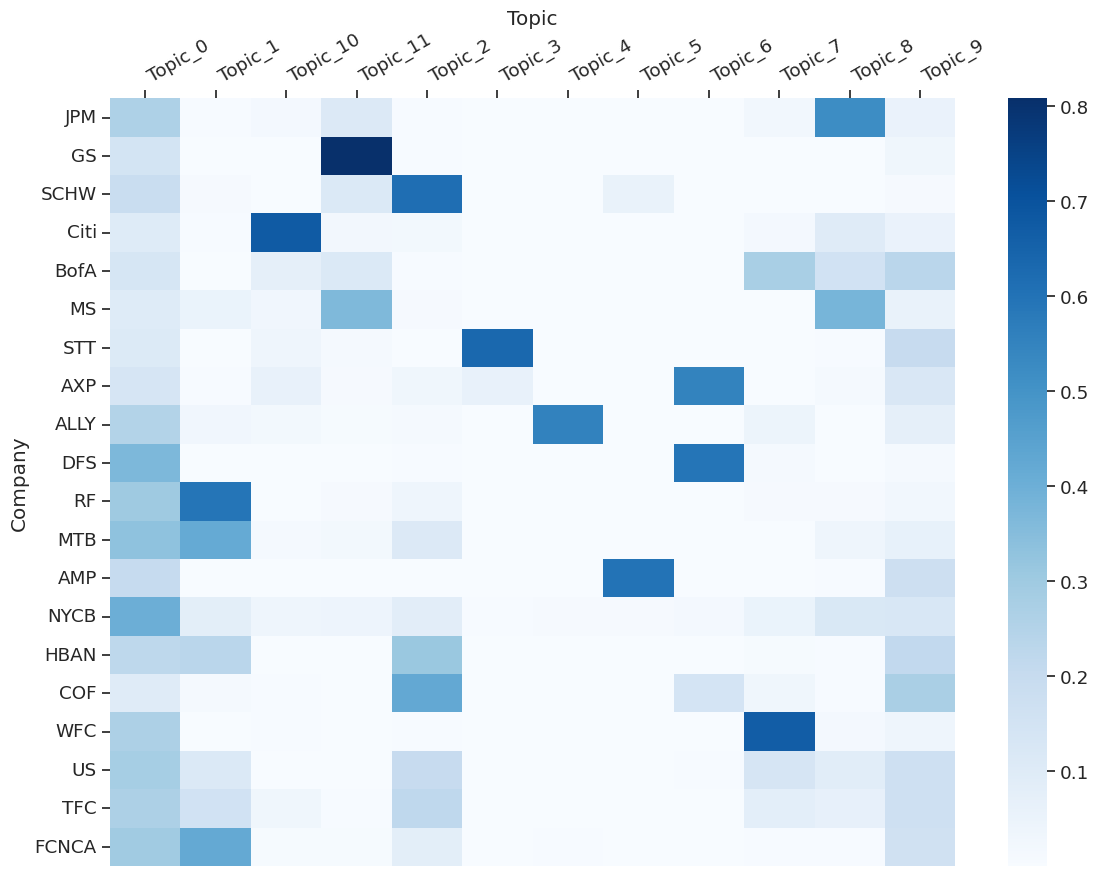

In [ ]:
#Heatmap
#Calculate periodic averages for each topic for each firm
topic_mean_df = topic_df.groupby('Company').mean()

# Adjust Data Frame for creating a heatmap
topic_mean_df.reset_index(inplace=True)
topic_mean_df_melted = topic_mean_df.melt(id_vars='Company', var_name='Topic', value_name='Average Probability')
topic_mean_df_melted = topic_mean_df_melted[topic_mean_df_melted['Topic'] != 'Type']

company_order = ['JPM', 'GS', 'SCHW','Citi','BofA','MS','STT','AXP','ALLY','DFS','RF','MTB','AMP','NYCB','HBAN','COF','WFC','US','TFC','FCNCA']
topic_mean_df_melted['Company'] = pd.Categorical(topic_mean_df_melted['Company'], categories=company_order, ordered=True)
topic_mean_df_melted = topic_mean_df_melted.sort_values(by='Company')

# Create a heatmap
def plot_topics_heatmap(df, color_map=sns.cm.rocket_r, dim=None):
    df_wide = df.pivot_table(index='Company', columns='Topic', values='Average Probability')

    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_wide, cmap=color_map)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

plot_topics_heatmap(topic_mean_df_melted, color_map='Blues', dim=(12, 9))


Financial institutions in the upper half of this table are classified as Type 2, while those in the lower half are classified as Type 1. Topic 11 (Liquidity) and Topic 8 (Compliance) show higher probabilities among Type 2 institutions. Meanwhile, Topic 1 (Relationship with Stockholders) and Topic 2 (M&A) are more probable among Type 1 institutions. Both types of institutions exhibit high probabilities in Topic 0 (Interest Rate) and Topic 9 (Cyber Attack).


Below is the stacked area chart for Total, Type 1 and Type 2. This chart enables us to understand the changes in risk trends.


**Total**

<ipython-input-14-b8bb09a6d41d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_mean_df = topic_df.groupby('Year').mean()


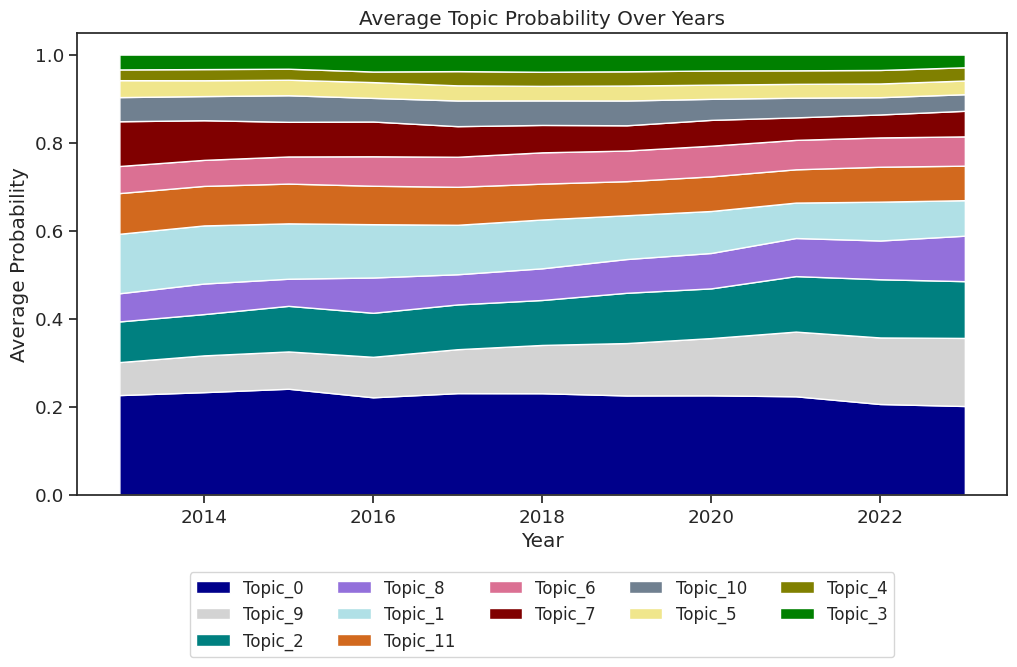

In [ ]:
## Stack area chart
topic_colors = {
    'Topic_0': 'darkblue',
    'Topic_1': 'powderblue',
    'Topic_2': 'teal',
    'Topic_3': 'green',
    'Topic_4': 'olive',
    'Topic_5': 'khaki',
    'Topic_6': 'palevioletred',
    'Topic_7': 'maroon',
    'Topic_8': 'mediumpurple',
    'Topic_9': 'lightgray',
    'Topic_10':'slategrey',
    'Topic_11':'chocolate'
}
# Convert "Year" to numeric type
topic_df['Year'] = pd.to_numeric(topic_df['Year'])
# Calculate average for each year
yearly_mean_df = topic_df.groupby('Year').mean()
yearly_mean_df.drop(columns='Type', inplace=True)
# Sort topics by the value of the latest year
latest_year_values = yearly_mean_df.iloc[-1]
sorted_topics = latest_year_values.sort_values(ascending=False).index
# Create the stack area chart
colors = [topic_colors[topic] for topic in sorted_topics]

plt.figure(figsize=(12, 6))
plt.stackplot(yearly_mean_df.index,
              [yearly_mean_df[topic] for topic in sorted_topics],
              labels=sorted_topics,
              colors=colors)
plt.xlabel('Year')
plt.ylabel('Average Probability')
plt.title('Average Topic Probability Over Years')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize='small')
plt.show()

**Type 1** **: Loan-oriented**

<ipython-input-15-a93cf7e5b59c>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_mean_df2 = topic_df1.groupby('Year').mean()


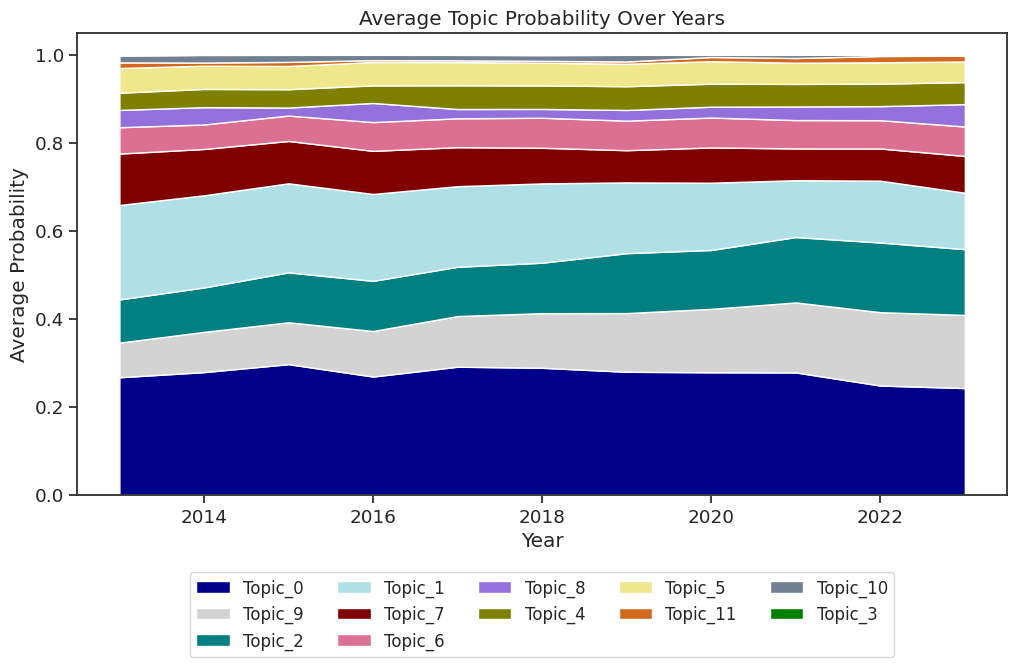

In [ ]:
topic_df1 = topic_df[topic_df['Type'] != 2]
yearly_mean_df2 = topic_df1.groupby('Year').mean()
yearly_mean_df2.drop(columns='Type', inplace=True)

latest_year_values = yearly_mean_df2.iloc[-1]

sorted_topics = latest_year_values.sort_values(ascending=False).index

colors = [topic_colors[topic] for topic in sorted_topics]

plt.figure(figsize=(12, 6))
plt.stackplot(yearly_mean_df2.index,
              [yearly_mean_df2[topic] for topic in sorted_topics],
              labels=sorted_topics,
              colors=colors)
plt.xlabel('Year')
plt.ylabel('Average Probability')
plt.title('Average Topic Probability Over Years')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize='small')
plt.show()


**Type2: Capital market-oriented**

<ipython-input-16-dc6883c11ee6>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_mean_df3 = topic_df2.groupby('Year').mean()


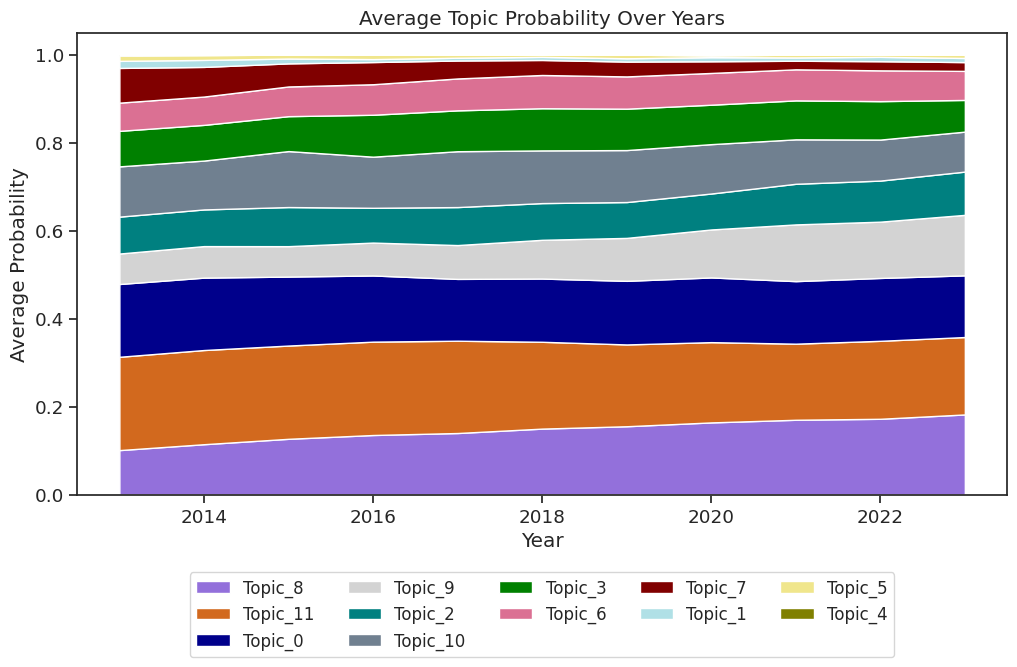

In [ ]:
topic_df2 = topic_df[topic_df['Type'] != 1]
yearly_mean_df3 = topic_df2.groupby('Year').mean()
yearly_mean_df3.drop(columns='Type', inplace=True)

latest_year_values = yearly_mean_df3.iloc[-1]

sorted_topics = latest_year_values.sort_values(ascending=False).index

colors = [topic_colors[topic] for topic in sorted_topics]

plt.figure(figsize=(12, 6))
plt.stackplot(yearly_mean_df3.index,
              [yearly_mean_df3[topic] for topic in sorted_topics],
              labels=sorted_topics,
              colors=colors)
plt.xlabel('Year')
plt.ylabel('Average Probability')
plt.title('Average Topic Probability Over Years')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize='small')
plt.show()

Below is another way of illustrating the changes in risk trends.


**Total**

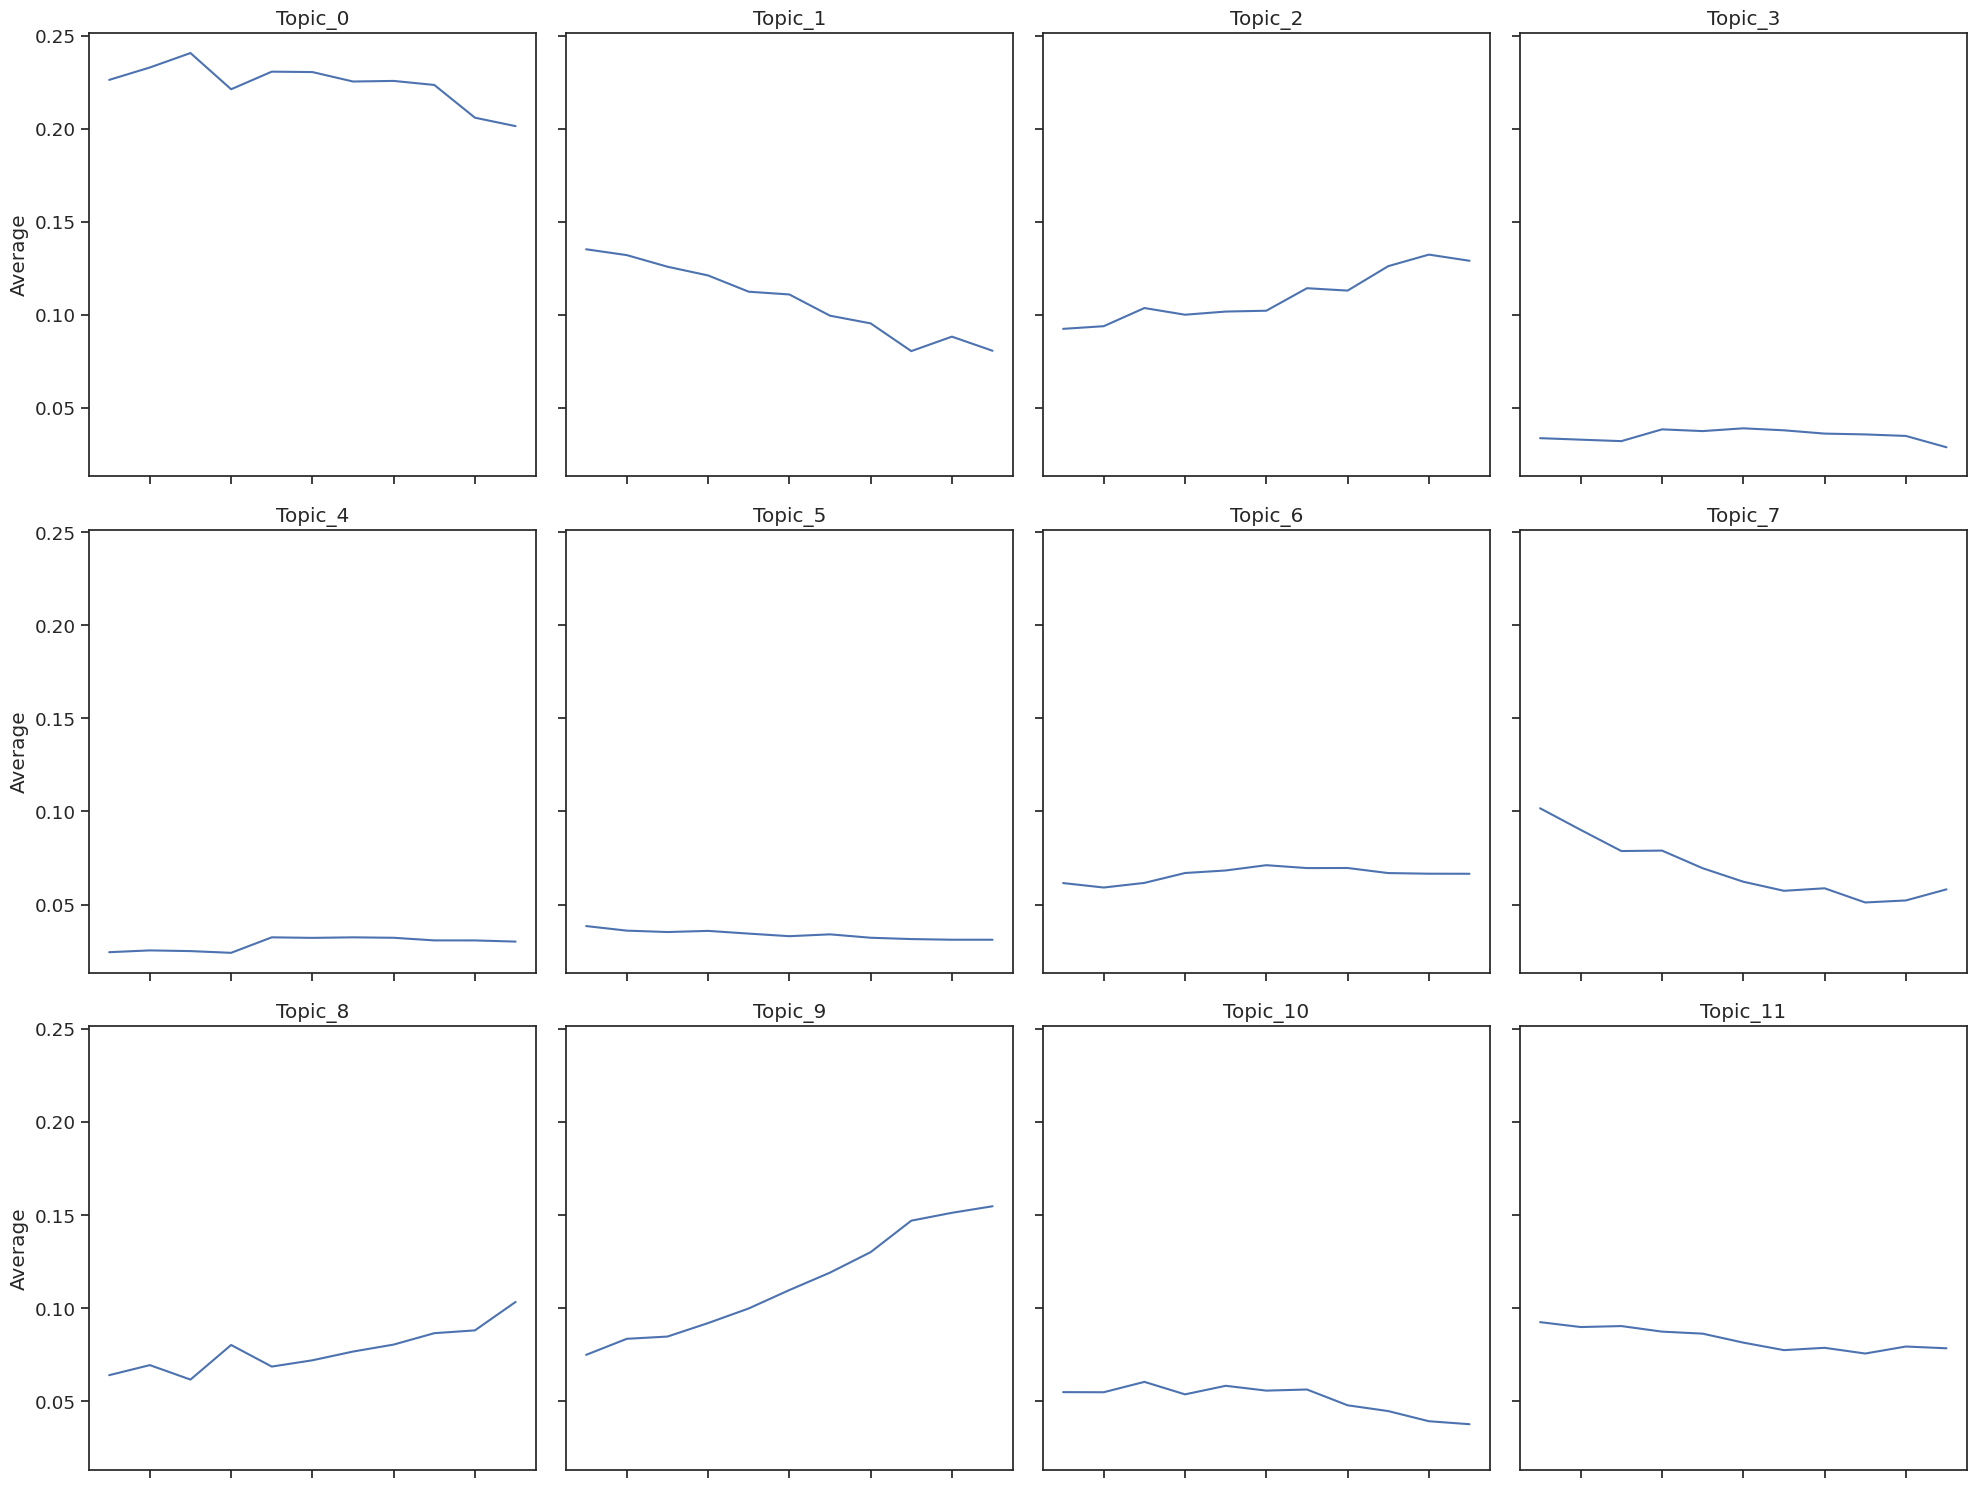

In [ ]:
##Line chart
# Setting the number of rows and columns
n_rows = 4
n_cols = 4
# Creating line charts for each topic
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)
for i, topic in enumerate(yearly_mean_df.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    yearly_mean_df[topic].plot(ax=ax)
    ax.set_title(topic)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')

for i in range(len(yearly_mean_df.columns), n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

plt.tight_layout()
plt.show()


**Type1**

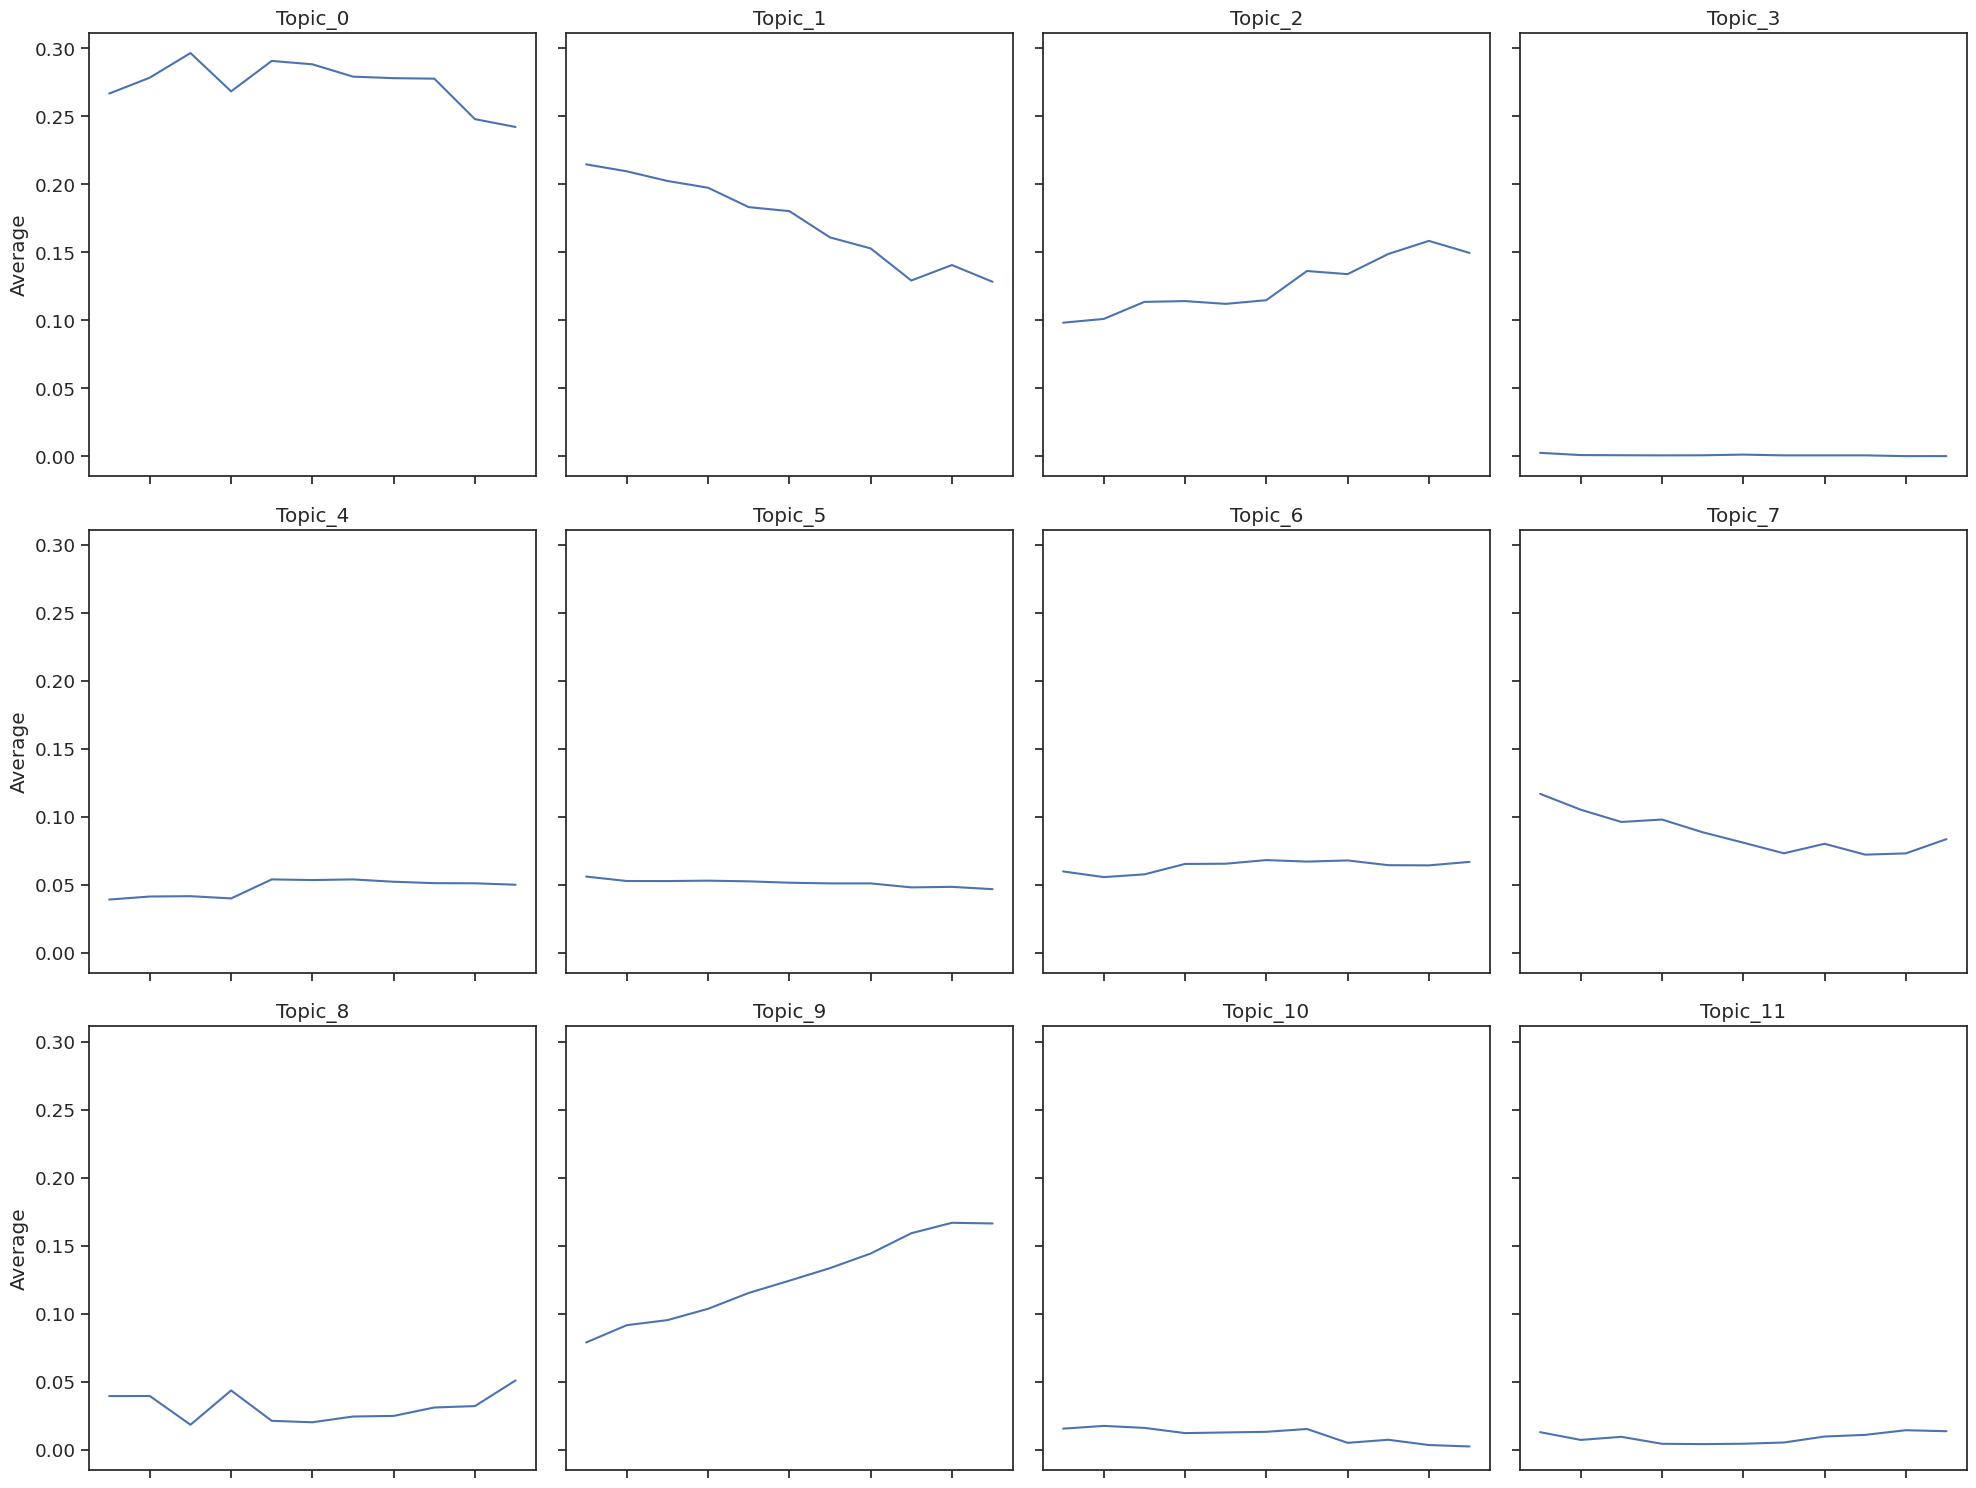

In [ ]:

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)
for i, topic in enumerate(yearly_mean_df2.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    yearly_mean_df2[topic].plot(ax=ax)
    ax.set_title(topic)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')

for i in range(len(yearly_mean_df2.columns), n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

plt.tight_layout()
plt.show()


**Type2**

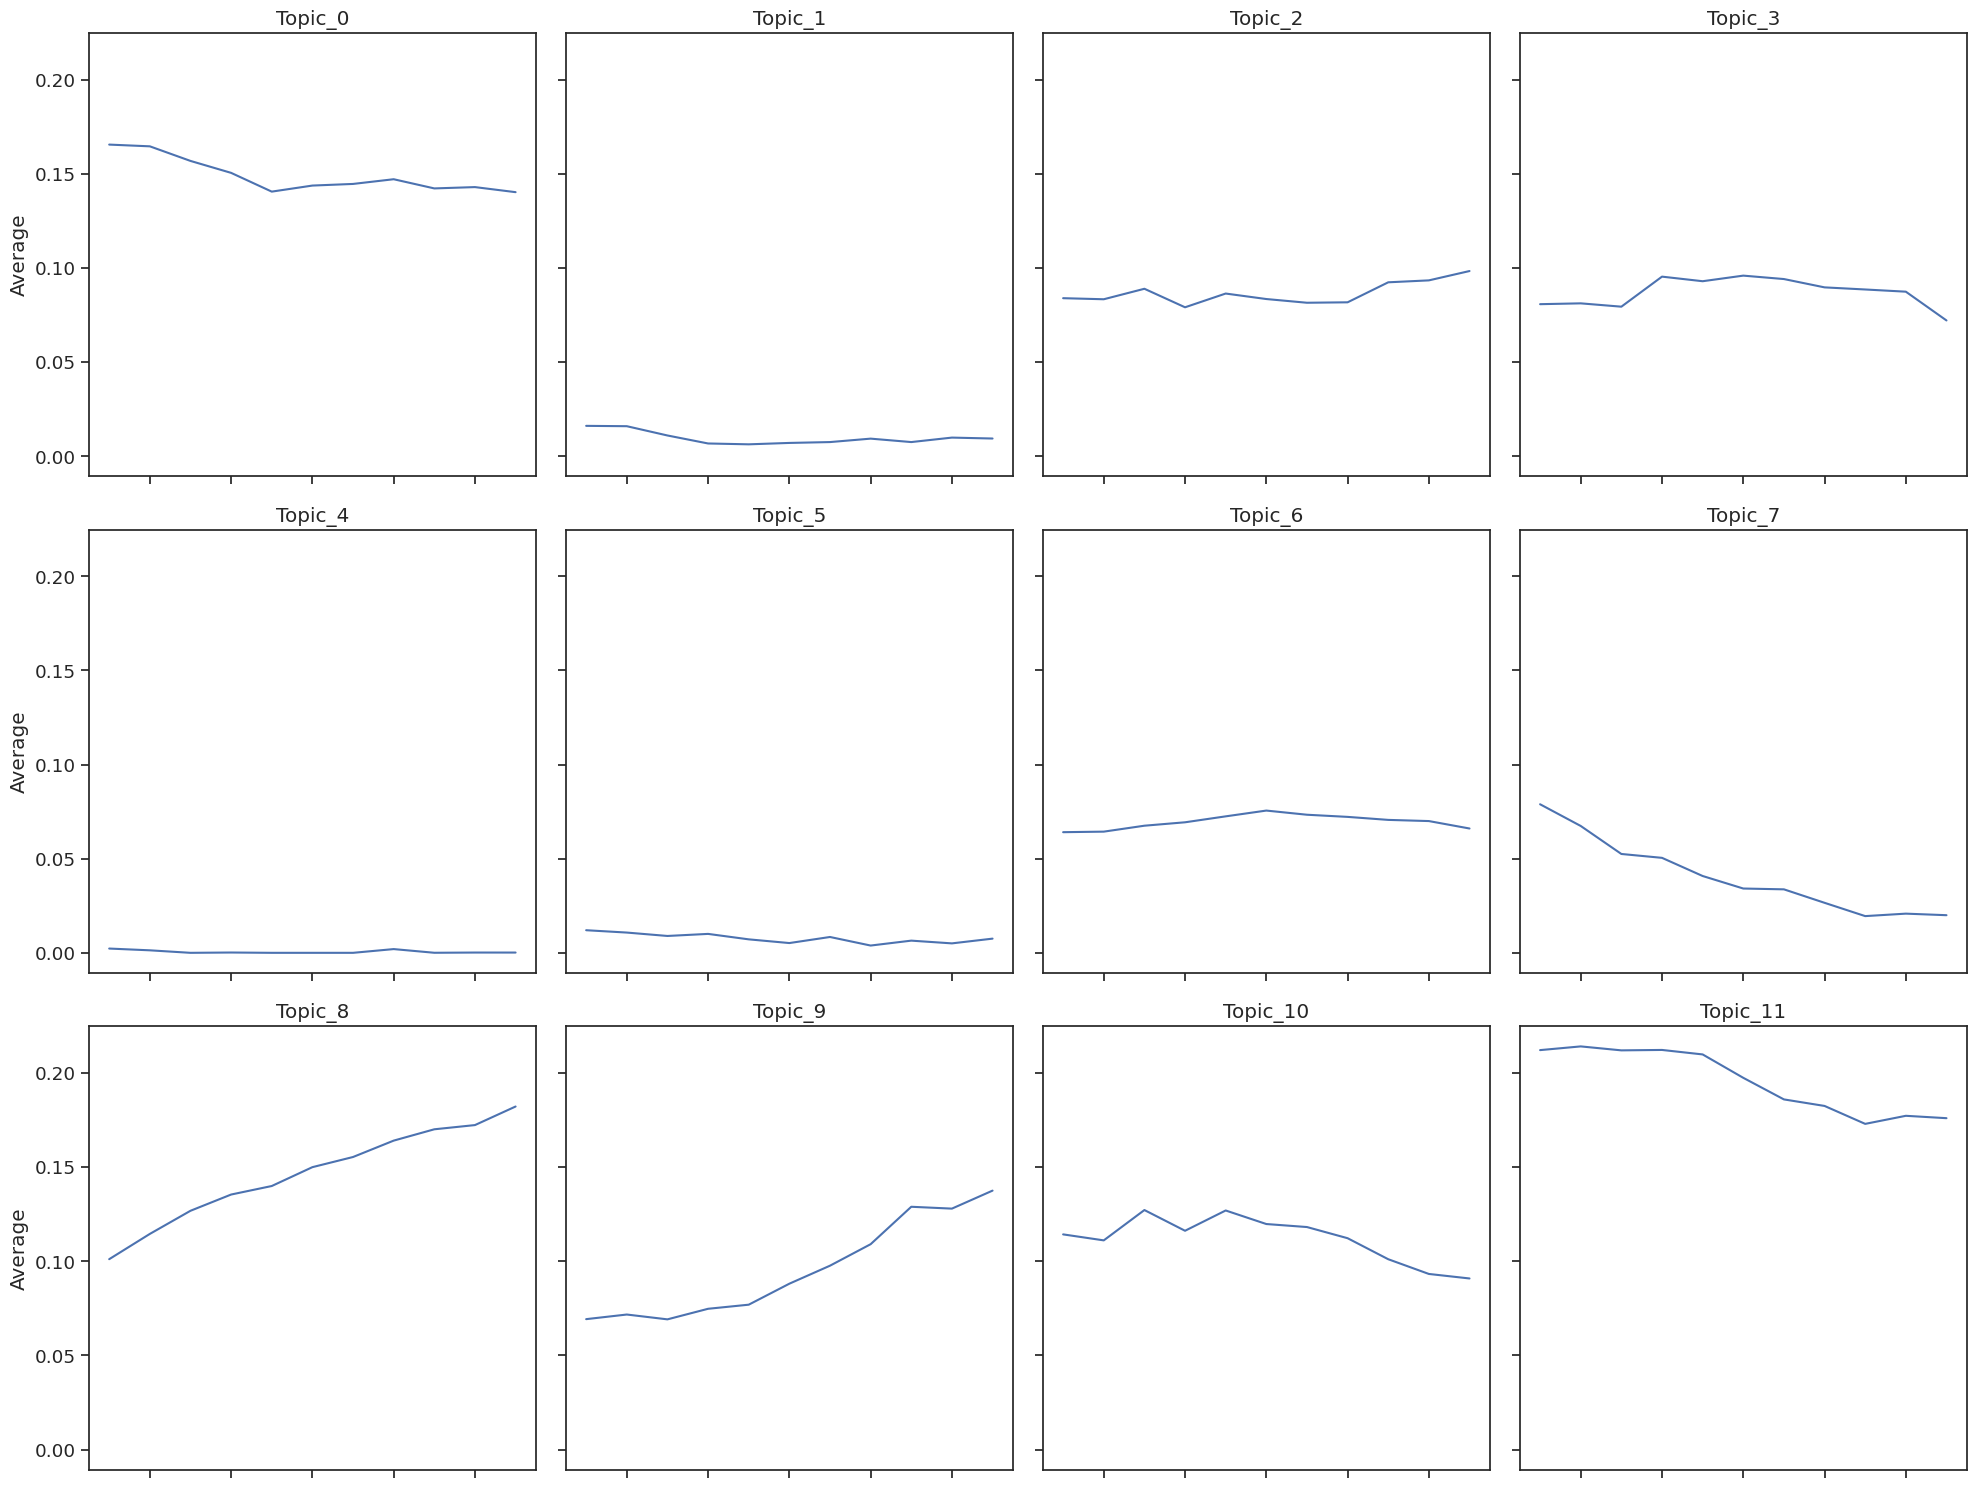

In [ ]:

n_rows = 4
n_cols = 4

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True, sharey=True)
for i, topic in enumerate(yearly_mean_df3.columns):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    yearly_mean_df3[topic].plot(ax=ax)
    ax.set_title(topic)
    ax.set_xlabel('Year')
    ax.set_ylabel('Average')

for i in range(len(yearly_mean_df3.columns), n_rows * n_cols):
    fig.delaxes(axes[i // n_cols, i % n_cols])

plt.tight_layout()
plt.show()


<u>**Key Findings**</u>

Key findings through these data visualization are the following:

1. Among both types, the probability of Topic 9 (Cyber Attack) has been increasing. There have been notable shifts, especially with the proliferation of mobile interfaces like smartphones and tablets, as well as cutting-edge digital technologies including AI. In line with these technological advancements, the cybersecurity risks facing financial institutions have increased dramatically.

2. The probability of Topic 2 (M&A) has been rising in Type 1 institutions. The 2018 amendments to the Dodd-Frank Act, which raised the thresholds for stringent regulations and supervision, have made mergers and acquisitions more feasible for banks. The data suggests that banks are indeed increasing their involvement in M&As, leading to greater exposure to M&A-related risks.

3. The probability of Topic 2 (Compliance) has been rising in Type 2 institutions. All the financial institutions classified as Type 2 are global systemically important banks (G-SIBs), and regulations on these institutions have become stricter following the Great Financial Crisis in 2008. The data implies that Type 2 institutions are facing increasing compliance and legal risks corresponding to the heightened regulations.






Additionaly, I made attack area charts for each financial institution. These charts enable us to observe the change in each financial institution’s risk situation. Due to the word count limit, a detailed discussion for these charts is omitted.


<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


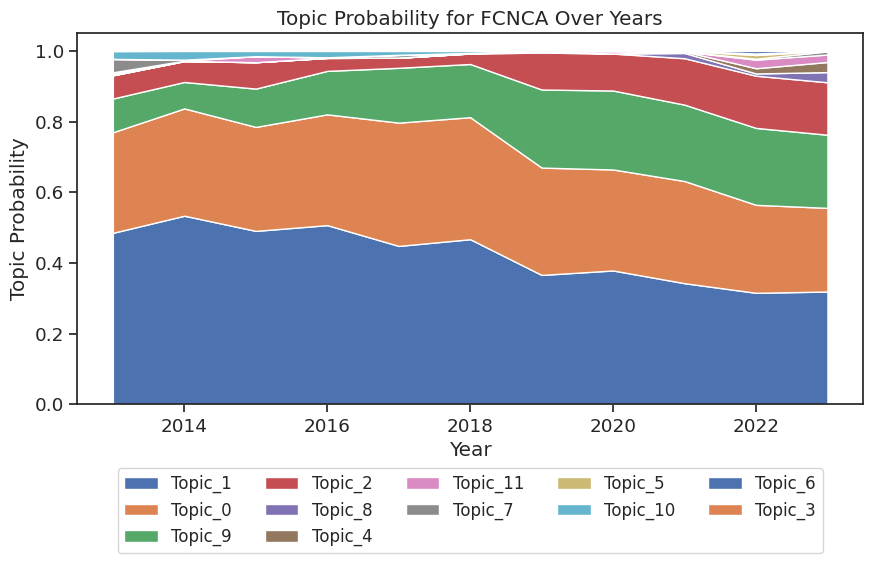

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


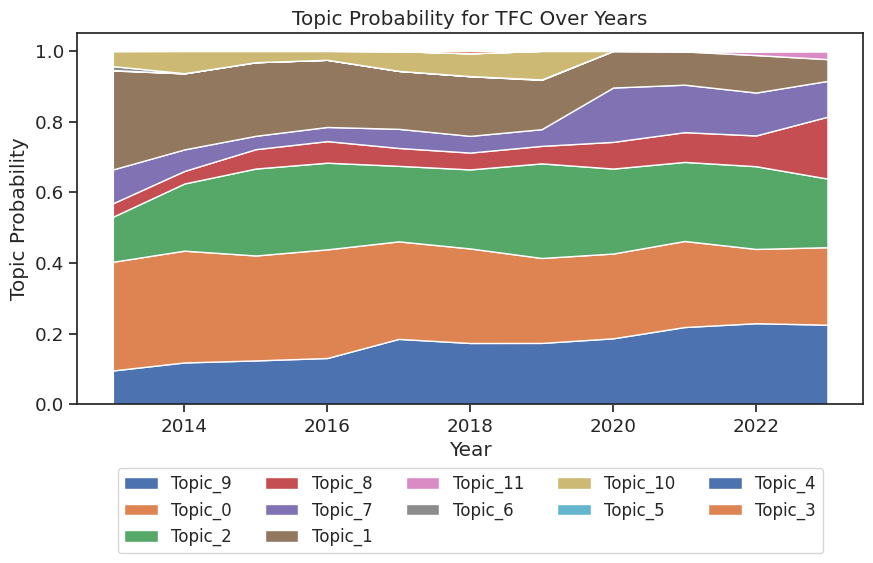

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


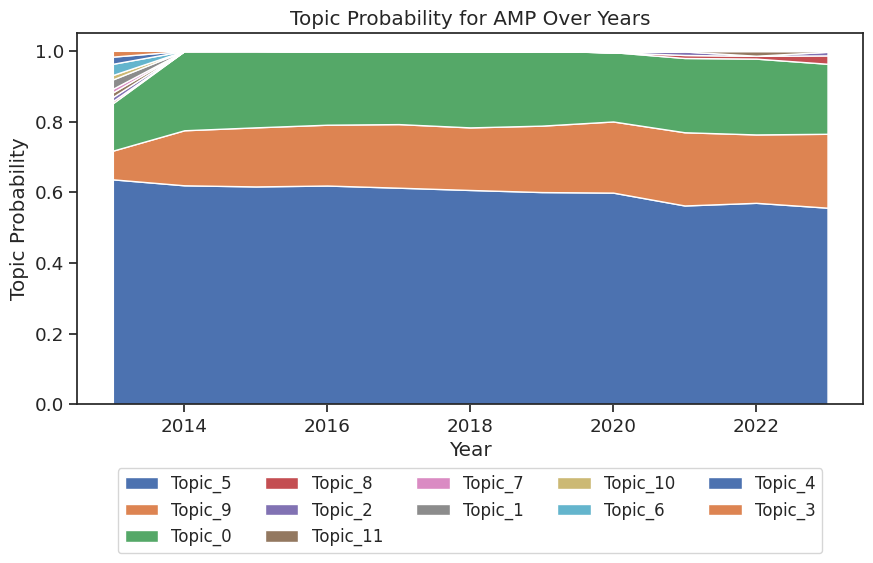

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


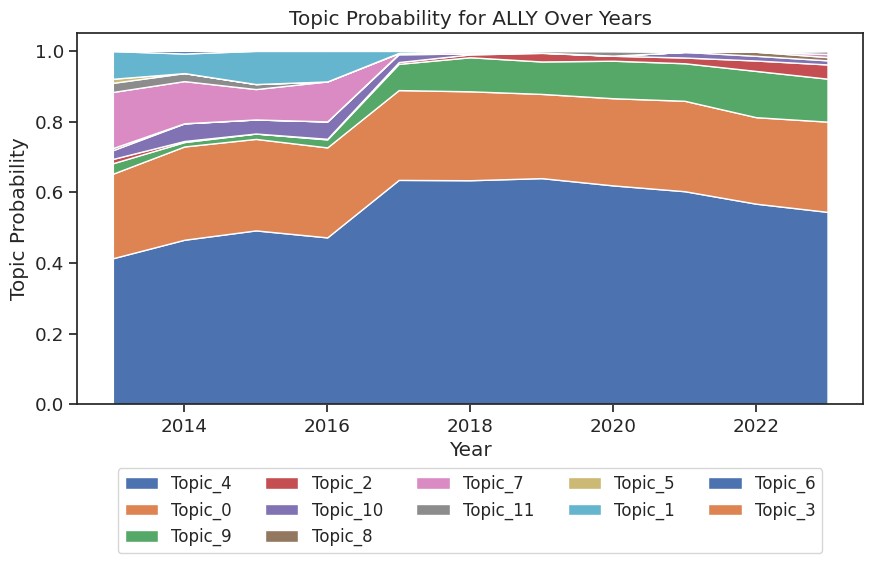

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


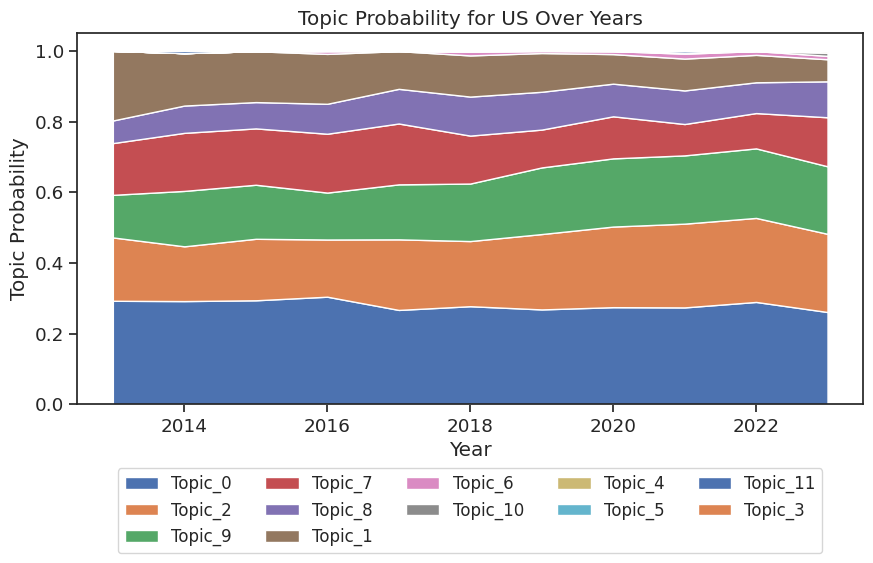

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


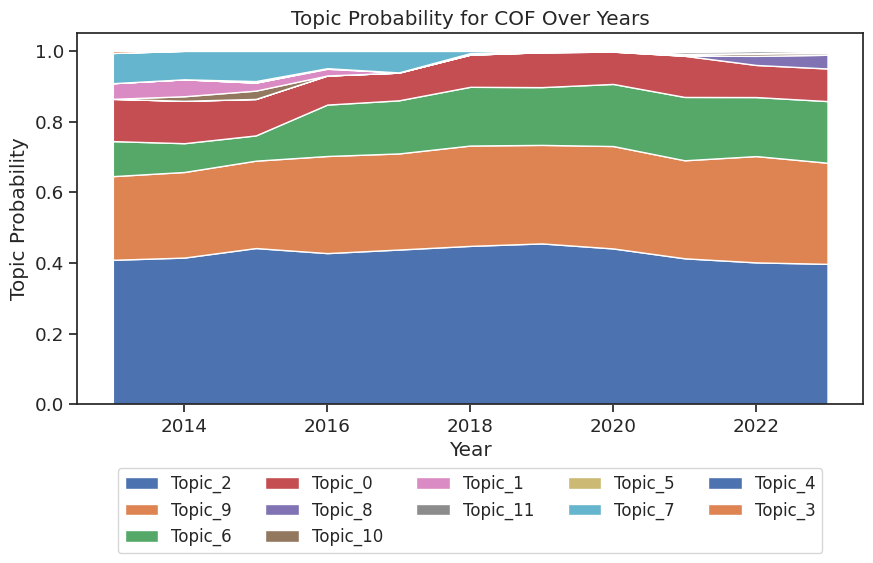

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


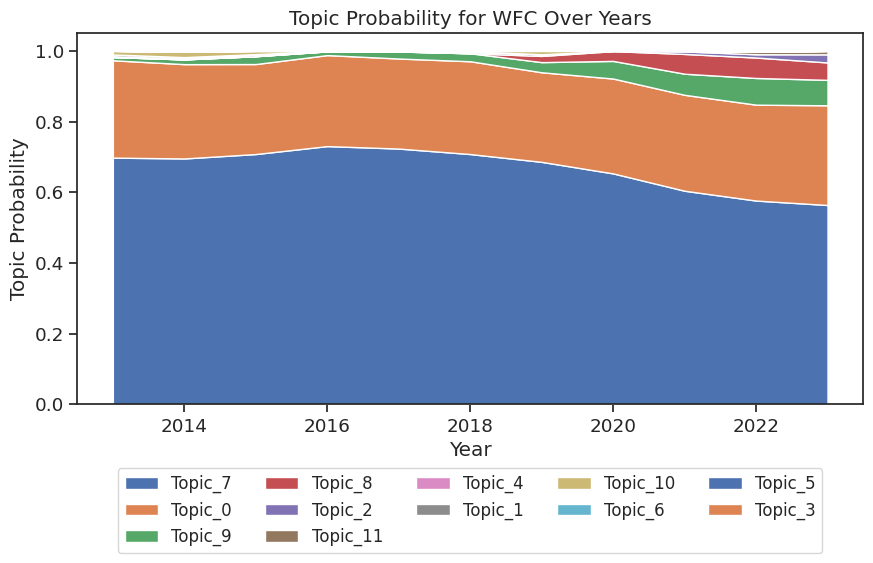

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


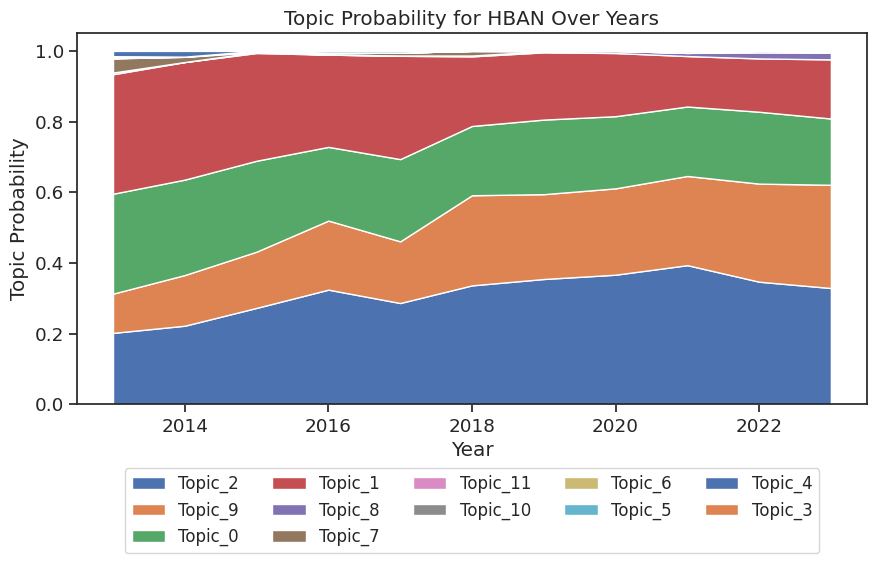

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


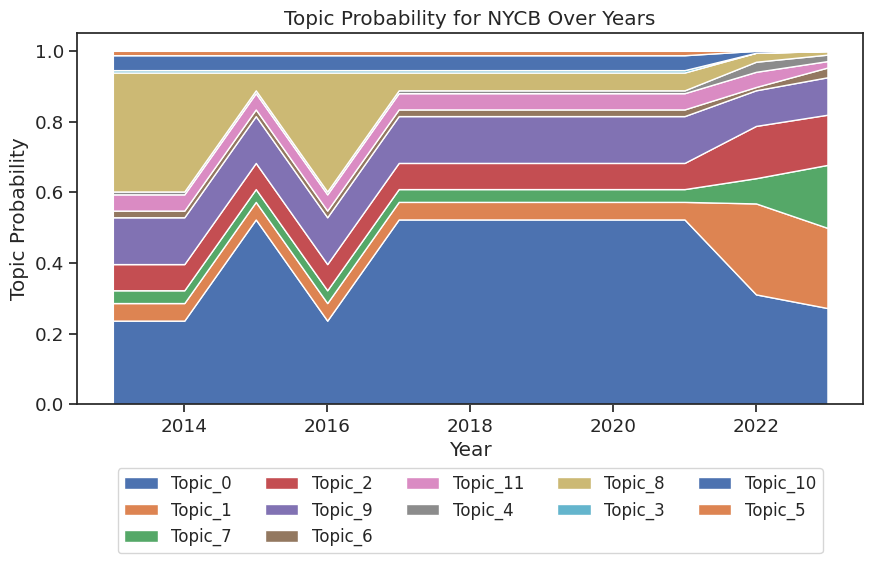

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


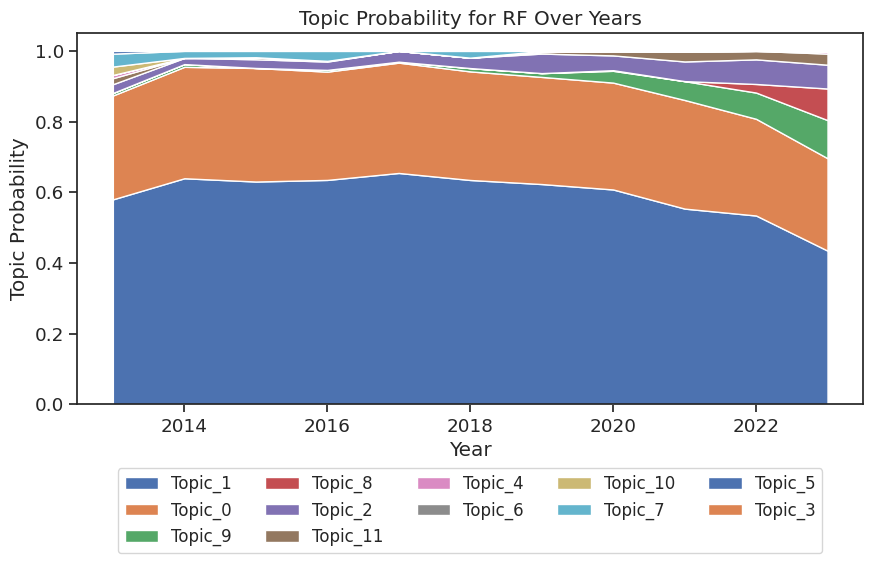

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


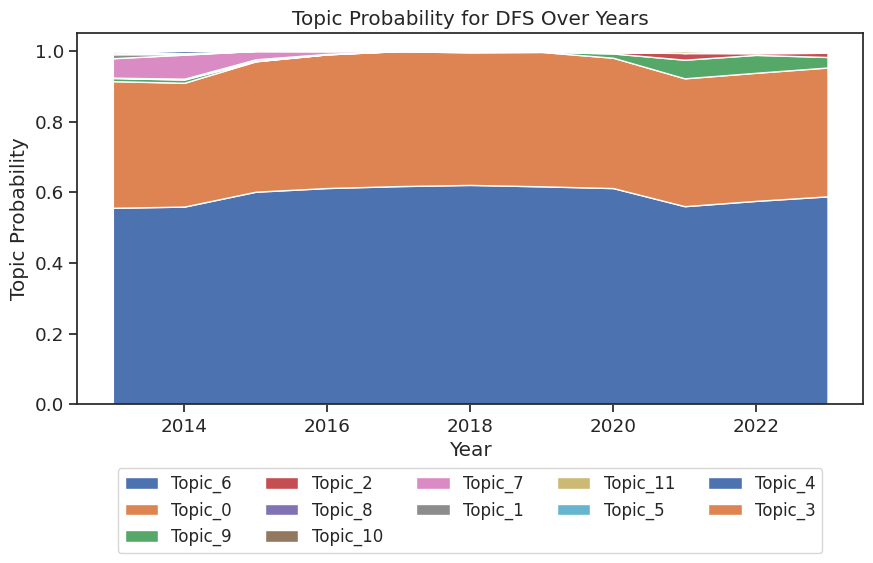

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


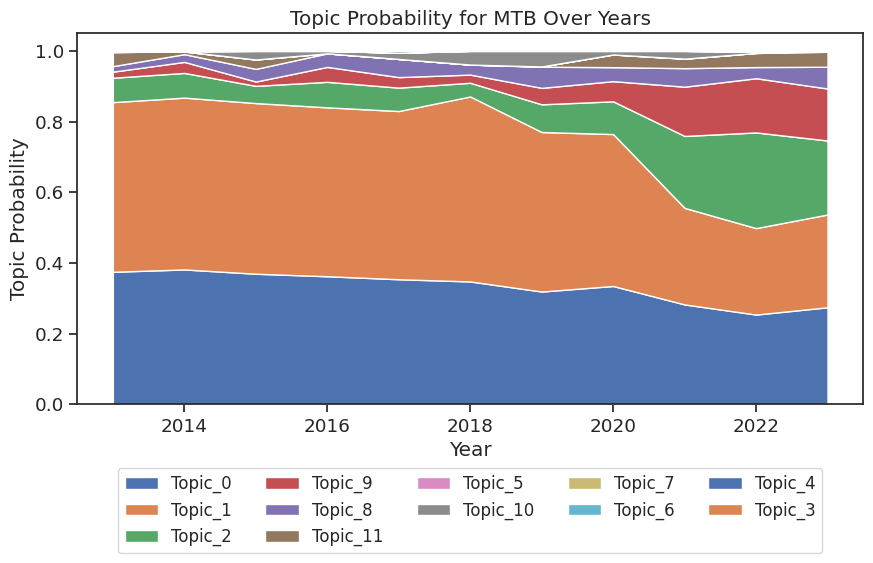

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


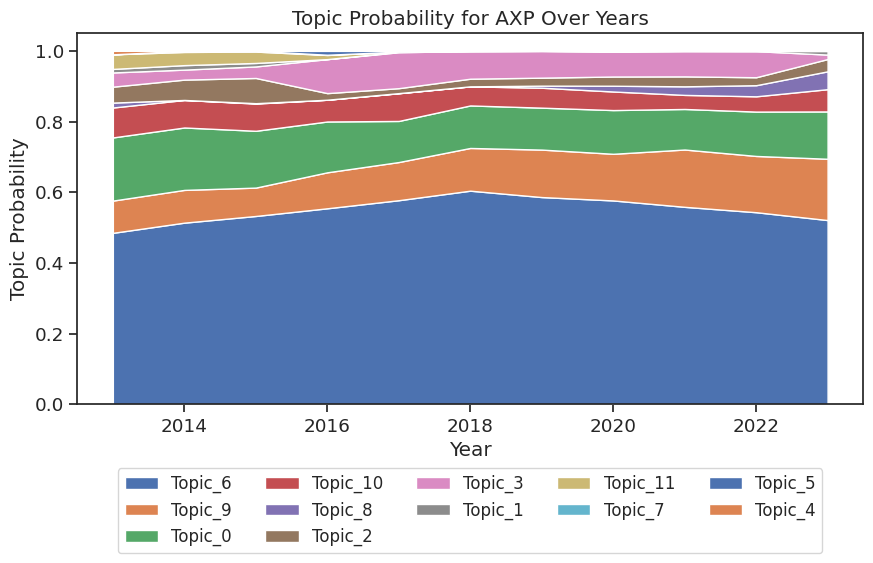

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


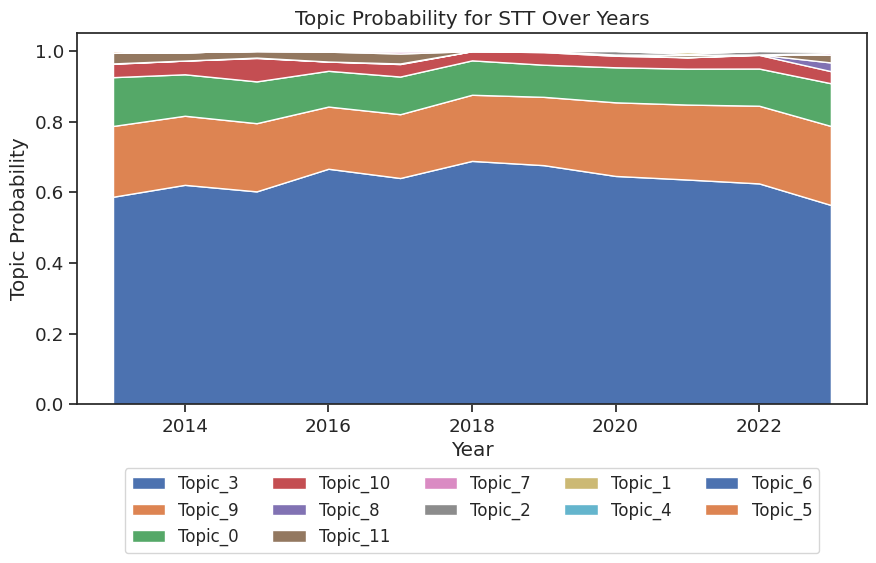

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


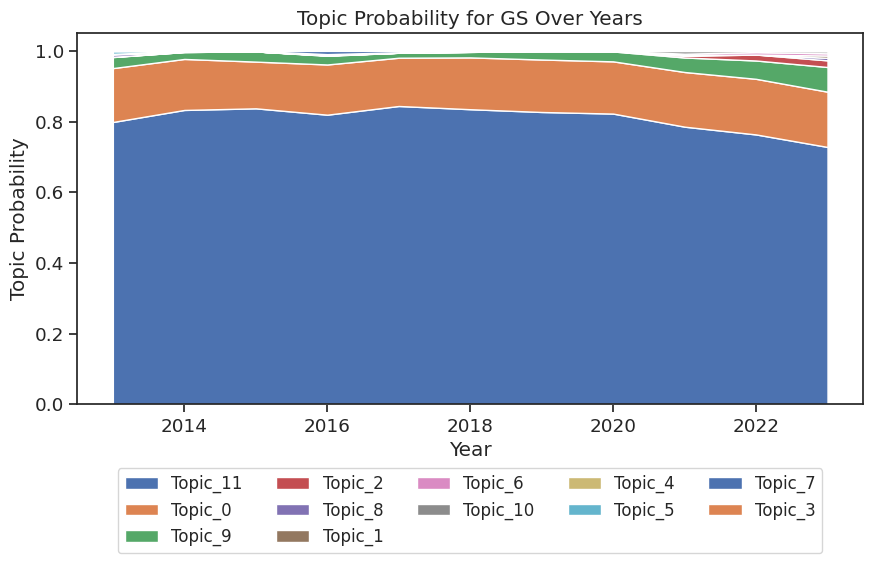

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


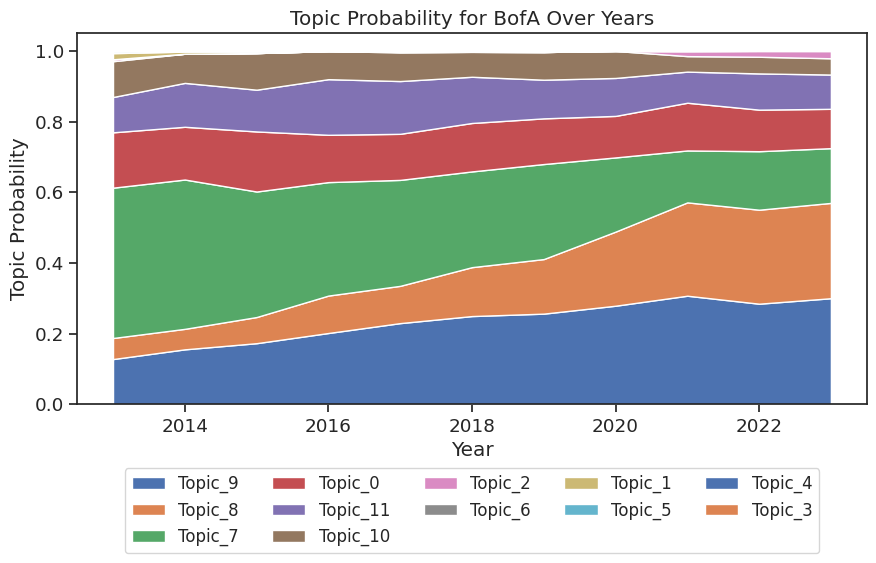

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


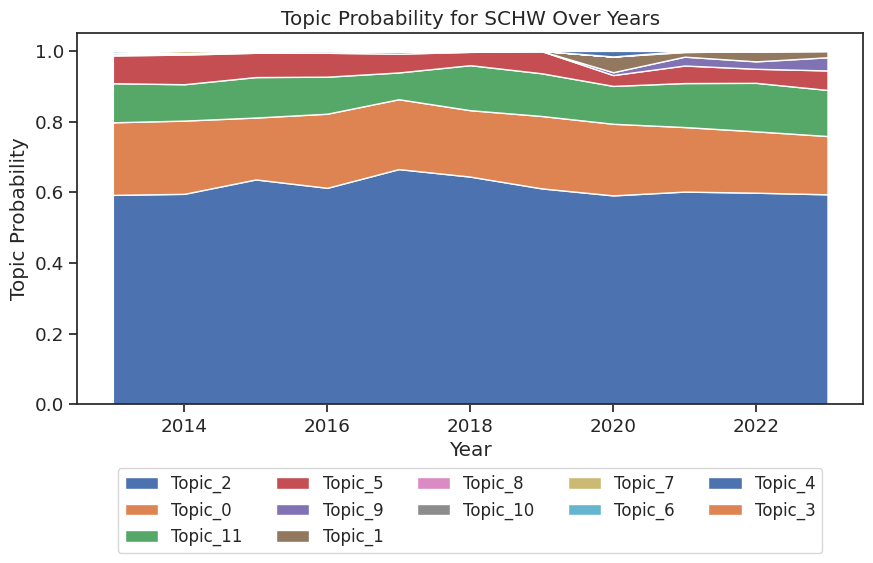

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


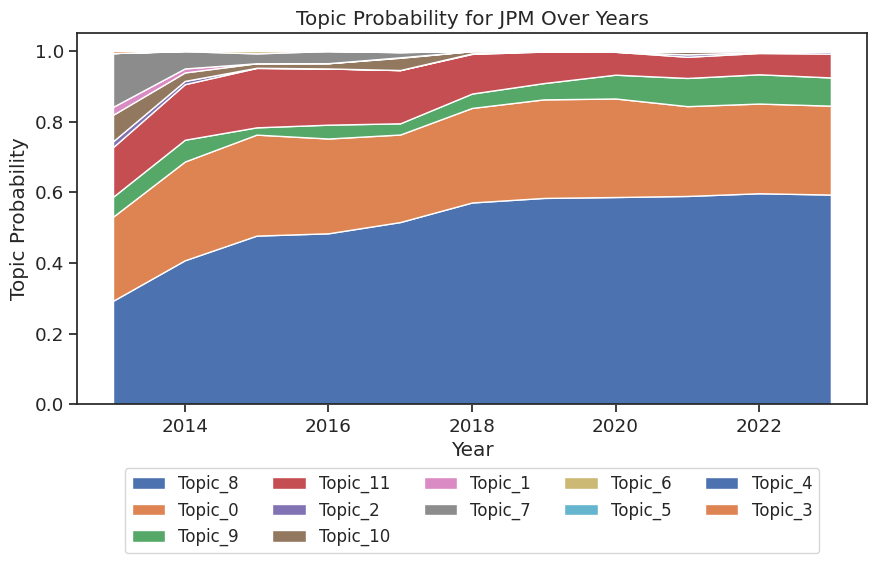

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


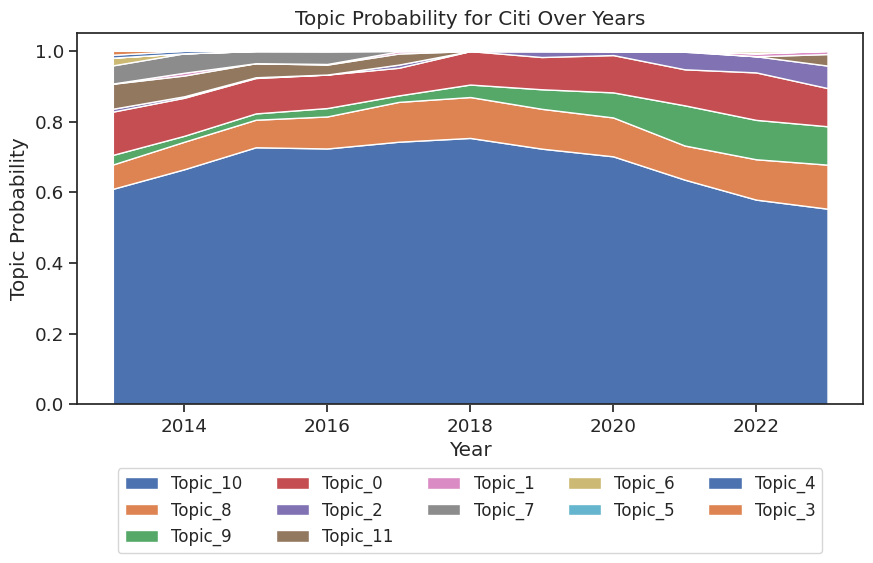

<ipython-input-20-0cafb43deb20>:9: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sorted_topics = latest_year_data.mean().sort_values(ascending=False).index


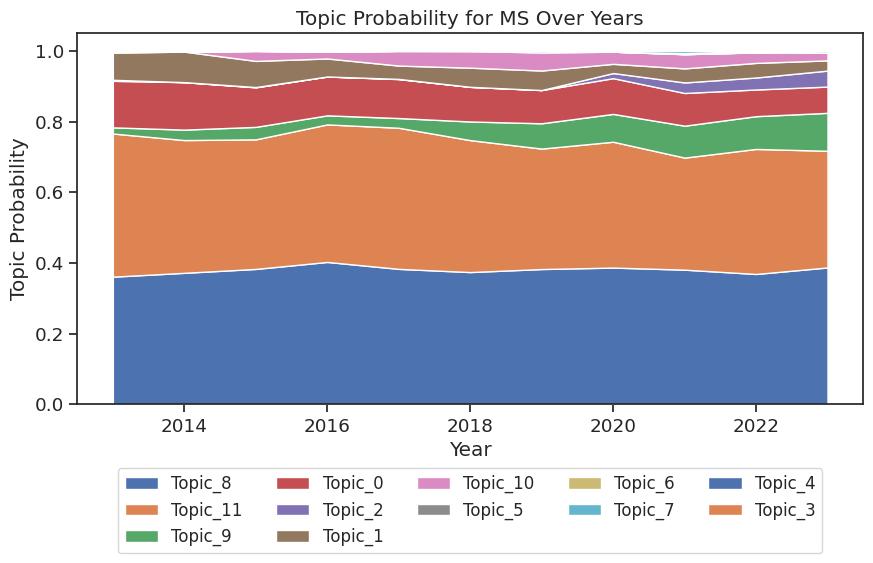

In [ ]:

for company in topic_df['Company'].unique():
    plt.figure(figsize=(9, 6))
    company_data = topic_df[topic_df['Company'] == company].sort_values(by='Year')
    company_data.drop(columns='Type', inplace=True)

    latest_year_data = company_data[company_data['Year'] == company_data['Year'].max()]
    sorted_topics = latest_year_data.mean().sort_values(ascending=False).index

    plt.stackplot(company_data['Year'],
                  [company_data[topic] for topic in sorted_topics if 'Topic' in topic],
                  labels=[topic for topic in sorted_topics if 'Topic' in topic])
    plt.xlabel('Year')
    plt.ylabel('Topic Probability')
    plt.title(f'Topic Probability for {company} Over Years')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize='small')
    plt.tight_layout()
    plt.show()


# TFIDF

To capture risk trends from another perspective, I computed TF-IDF values of words in the sample documents as a supplemental analysis. For the calculation of TF-IDF value, I follow the codes of the class material[(Krisel, 2023)](https://github.com/rskrisel/tf-idf/blob/main/README.md).


In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
pd.options.display.max_rows = 600
from pathlib import Path
import glob
text_files = glob.glob(f"{path}/*.txt")
text_titles = [Path(text).stem for text in text_files]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(input='filename', stop_words='english')
tfidf_vector = tfidf_vectorizer.fit_transform(text_files)
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), index=text_titles, columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.loc['00_Document Frequency'] = (tfidf_df > 0).sum()
tfidf_df = tfidf_df.drop('00_Document Frequency', errors='ignore')
tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df = tfidf_df.rename(columns={0:'tfidf', 'level_0': 'document','level_1': 'term', 'level_2': 'term'})
tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)
top_tfidf = tfidf_df.sort_values(by=['document','tfidf'], ascending=[True,False]).groupby(['document']).head(10)

 The table below presents the top 10 most frequently appearing words for each financial institution, annually.


In [ ]:
import altair as alt
import numpy as np
# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001
# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'document:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["document"],
)
# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)
# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

After converting the output into a DataFrame, I calculated the average TF-IDF value for each word in each year, creating similar tables for Total, Type 1, and Type 2.

Furthermore, by assessing the change in the TF-IDF value of each word from 2013 to 2023, I identified the top 15 words with the most significant changes during this period and created line charts for each category. I referred to [INAF U6504 Python for Public Policy](https://python-public-policy.afeld.me/en/columbia/) to create a line chart.


In [ ]:
tfidf_df[['Company', 'Year']] = tfidf_df['document'].str.split('_', expand=True)
tfidf_df

,document,term,tfidf,Company,Year
0,GS_2014,aa,0.0,GS,2014
1,GS_2014,aaa,0.0,GS,2014
2,GS_2014,aac,0.0,GS,2014
3,GS_2014,aarc,0.0,GS,2014
4,GS_2014,ab,0.0,GS,2014
...,...,...,...,...,...
2609195,FCNCA_2013,york,0.0,FCNCA,2013
2609196,FCNCA_2013,zealand,0.0,FCNCA,2013
2609197,FCNCA_2013,zero,0.0,FCNCA,2013
2609198,FCNCA_2013,zika,0.0,FCNCA,2013


**Total**

In [ ]:

# Calculate averages for each conmaniy for each year
average_tfidf = tfidf_df.groupby(['Year', 'term'])['tfidf'].mean()
average_tfidf_df = average_tfidf.reset_index()
top_tfidf = average_tfidf_df.sort_values(by=['Year','tfidf'], ascending=[True,False]).groupby(['Year']).head(10)

# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'Year:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["Year"],
)
# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)
# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)
# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

alt.LayerChart(...)

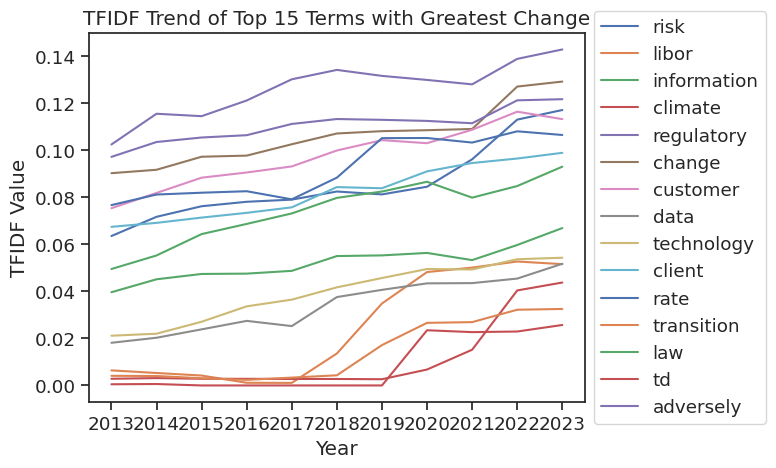

In [ ]:
# Filter data of 2013 and 2023
data_2013 = average_tfidf_df[average_tfidf_df['Year'] == '2013']
data_2023 = average_tfidf_df[average_tfidf_df['Year'] == '2023']
# Merge data of these two years
merged_data = data_2013.merge(data_2023, on='term', suffixes=['_2013', '_2023'])
# Calculate the change in TF-IDF
merged_data['tfidf_change'] = merged_data['tfidf_2023'] - merged_data['tfidf_2013']
# Extract yhe to 15 words with the greatest change in TFIDF value
top_15_terms = merged_data.nlargest(15, 'tfidf_change')['term']
# Create a line chart
for term in top_15_terms:
    term_data = average_tfidf_df[average_tfidf_df['term'] == term]
    plt.plot(term_data['Year'], term_data['tfidf'], label=term)

plt.xlabel('Year')
plt.ylabel('TFIDF Value')
plt.title('TFIDF Trend of Top 15 Terms with Greatest Change')
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))

**Type1**

In [ ]:

filtered_df = tfidf_df[~tfidf_df['Company'].isin(['JPM', 'GS', 'SCHW','Citi','BofA','MS'])]

average_tfidf = filtered_df.groupby(['Year', 'term'])['tfidf'].mean()

average_tfidf_df = average_tfidf.reset_index()

top_tfidf = average_tfidf_df.sort_values(by=['Year','tfidf'], ascending=[True,False]).groupby(['Year']).head(10)

top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001


base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'Year:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["Year"],
)


heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)



text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)


(heatmap + text).properties(width = 600)


alt.LayerChart(...)

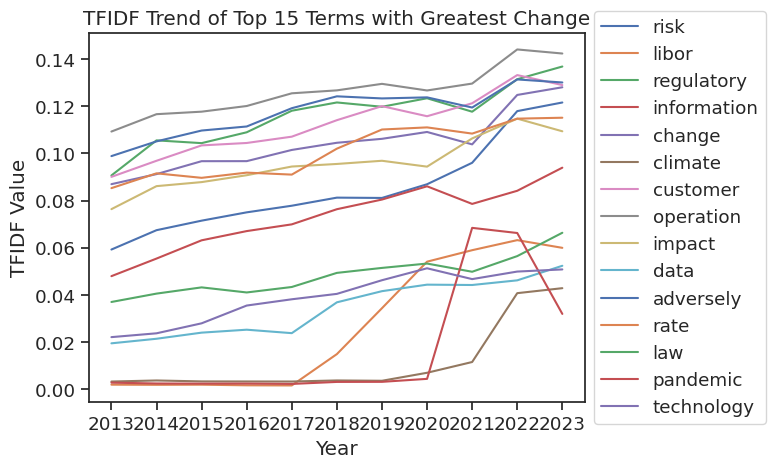

In [ ]:

data_2013 = average_tfidf_df[average_tfidf_df['Year'] == '2013']
data_2023 = average_tfidf_df[average_tfidf_df['Year'] == '2023']

merged_data = data_2013.merge(data_2023, on='term', suffixes=['_2013', '_2023'])

merged_data['tfidf_change'] = merged_data['tfidf_2023'] - merged_data['tfidf_2013']

top_15_terms = merged_data.nlargest(15, 'tfidf_change')['term']

for term in top_15_terms:
    term_data = average_tfidf_df[average_tfidf_df['term'] == term]
    plt.plot(term_data['Year'], term_data['tfidf'], label=term)

plt.xlabel('Year')
plt.ylabel('TFIDF Value')
plt.title('TFIDF Trend of Top 15 Terms with Greatest Change')
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

**Type2**

In [ ]:

filtered_df = tfidf_df[tfidf_df['Company'].isin(['JPM', 'GS', 'SCHW','Citi','BofA','MS'])]

average_tfidf = filtered_df.groupby(['Year', 'term'])['tfidf'].mean()

average_tfidf_df = average_tfidf.reset_index()

top_tfidf = average_tfidf_df.sort_values(by=['Year','tfidf'], ascending=[True,False]).groupby(['Year']).head(10)

top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['tfidf'] = top_tfidf_plusRand['tfidf'] + np.random.rand(top_tfidf.shape[0])*0.0001


base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'Year:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("tfidf", order="descending")],
    groupby = ["Year"],
)


heatmap = base.mark_rect().encode(
    color = 'tfidf:Q'
)



text = base.mark_text(baseline='middle').encode(
    text = 'term:N',
    color = alt.condition(alt.datum.tfidf >= 0.23, alt.value('white'), alt.value('black'))
)


(heatmap + text).properties(width = 600)


alt.LayerChart(...)

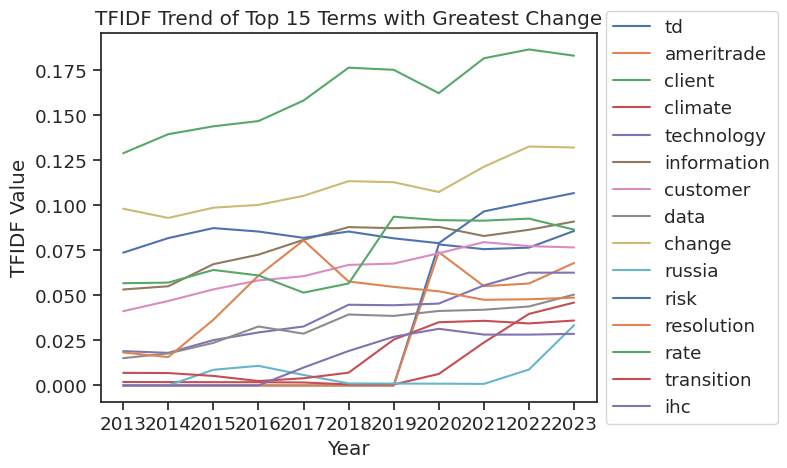

In [ ]:

data_2013 = average_tfidf_df[average_tfidf_df['Year'] == '2013']
data_2023 = average_tfidf_df[average_tfidf_df['Year'] == '2023']

merged_data = data_2013.merge(data_2023, on='term', suffixes=['_2013', '_2023'])

merged_data['tfidf_change'] = merged_data['tfidf_2023'] - merged_data['tfidf_2013']

top_15_terms = merged_data.nlargest(15, 'tfidf_change')['term']

for term in top_15_terms:
    term_data = average_tfidf_df[average_tfidf_df['term'] == term]
    plt.plot(term_data['Year'], term_data['tfidf'], label=term)

plt.xlabel('Year')
plt.ylabel('TFIDF Value')
plt.title('TFIDF Trend of Top 15 Terms with Greatest Change')
plt.legend(loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

<u>**Key Findings**</u>

Key findings through TF-IDF analysis is the following:

1. As identified by topic modeling, IT-related words ('information' and 'technology') have increasingly appeared in both categories.

2. Similarly, the TF-IDF values of words associated with climate risk ('climate' and 'transition') have also been increasing in both categories. Notably, this type of risk was not captured in the topic modeling. This is likely because the concept of climate risk has become popular only fairly recently. Since topics were estimated using documents from the entire sample period, these climate-related words did not form a distinct topic.

3. The most recent topics, such as the Russian invasion of Ukraine and the COVID-19 pandemic, are well-captured.


# Conclusion
This research demonstrated the evolution of key risks in the U.S. financial sector by analyzing the text within Form 10-Ks over the past decade, utilizing both topic modeling and TF-IDF analysis. Topic modeling revealed the changing nature of risks perceived by financial institutions, highlighting divergent risk trends between institutions with different business models. Additionally, by integrating TF-IDF analysis, the robustness of the results obtained from topic modeling is confirmed. This approach also captures relatively recent topics that topic modeling alone might miss, such as climate risks and recent events like the pandemic and war.

The findings suggest that regulators can use qualitative information to monitor the risk landscape of financial institutions and identify key risks that require attention.

One limitation of this analysis is that text data used in this research were authored by the financial institutions themselves. This approach makes it challenging to identify risks that they may not perceive or disclose. Therefore, it would be beneficial to combine the methods used in this research with traditional approaches, such as quantitative analysis or direct dialogues with financial institutions.
